In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'




np.set_printoptions(suppress=True)

# Dataset Source is:
# https://emdhgcalae.nrp-nautilus.io/ttbar/data/HGCal22Data_signal_driven_ttbar_v11/nElinks_5/5Elinks_data.csv
# 
# Each line of efr.log is structured as follows:
# (val_i, bit_i) | emd_val
# val_i is the index of the validation input (i.e., physics event) passed to the auto encoder
# bit_i is the index of the bit that has been flipped (i.e., the location of the where the single fault was injected)
# emd_val is the emd value computed for the result of the indicated faulty model on the indicated validation input
#
# It should be noted that baseline_efr.log contains the emd values computed for the results of the non-faulty model on the indicated validation inputs
# The bit_i field can be ignored for this file since no bits were flipped.  


In [29]:
#I: Collect the baseline emd values
vi_to_baseline_emd  = dict()
vi_to_baseline_count = dict()

with open("/home/anmeza/GitHub/fastml-science/sensor-data-compression/baseline_efr.log") as f:
    for li, line in enumerate(f):
        if li > 0:
            try:
                curr_vi_bi, curr_emd = [substr.strip() for substr in line.split("|")]
                vi, bi = [int(val) for val in curr_vi_bi[1:-1].split(",")]
                try:
                    vi_to_baseline_emd[vi]  += float(curr_emd)
                    vi_to_baseline_count[vi] += 1
                except KeyError:
                    vi_to_baseline_emd[vi]  = float(curr_emd)
                    vi_to_baseline_count[vi] = 1
            except ValueError:
                pass


In [42]:
#I: Collect the faulty emd values
num_lines = 0
bi_to_demd  = dict()
bi_to_count = dict()

bi_to_emds   = dict()
bi_to_demds  = dict()

with open("/home/anmeza/GitHub/fastml-science/sensor-data-compression/efr_val_inputs_0-31_with_eager_exec copy.log") as f:
# with open("/home/anmeza/GitHub/fastml-science/sensor-data-compression/efx_emd_hesstrace_v0-31/efd_emd_hesstrace_v0-31_wo_kernel_assign.log", "r") as f:
    for li, line in enumerate(f):
        if li > 0:
            try:
                curr_vi_bi, curr_emd = [substr.strip() for substr in line.split("|")]
                vi, bi = [int(val) for val in curr_vi_bi[1:-1].split(",")]
                num_lines += 1
                try:
                    bi_to_demd[bi]  += float(curr_emd) #np.abs(vi_to_baseline_emd[vi] - float(curr_emd))
                    bi_to_count[bi] += 1
                except KeyError:
                    bi_to_demd[bi]   = float(curr_emd) #np.abs(vi_to_baseline_emd[vi] - float(curr_emd))
                    bi_to_count[bi]  = 1
                    #print(f"New bi from {curr_vi_bi} at line number: {li}")
            except ValueError:
                pass #print(line)
        # if len(bi_to_demd.keys()) == 10000:
        #     break 


print("Averaging EMD values for each bit")
for bi in bi_to_demd.keys():
    bi_to_demd[bi]  = bi_to_demd[bi]/bi_to_count[bi]

print("Normalizing Averaged EMD values for each bit")
min_emd = min(bi_to_demd.values())
max_emd = max(bi_to_demd.values())
print(f"Min EMD = {min_emd} | Max EMD = {max_emd}")
for bi in bi_to_demd.keys():
    bi_to_demd[bi]  = (bi_to_demd[bi] - min_emd)/(max_emd - min_emd)

print(num_lines)
max(bi_to_demd.keys())

Averaging EMD values for each bit
339200


10599

In [43]:
def get_wi(i_bi, i_bw):
    return int(i_bi/i_bw)

def get_wbi(i_bi, i_bw):
    return int(i_bi%i_bw)


wis  = list()
bis  = list()
demd = list()

for bi in bi_to_demd.keys():
    wis.append(get_wi(bi,5))
    bis.append(get_wbi(bi,5))
    if get_wbi(bi,5) == 0:
        demd.append(bi_to_demd[bi]) #demd.append(1.6)
    else:
        demd.append(bi_to_demd[bi])

    # if len(wis) == 1970:
    #     break

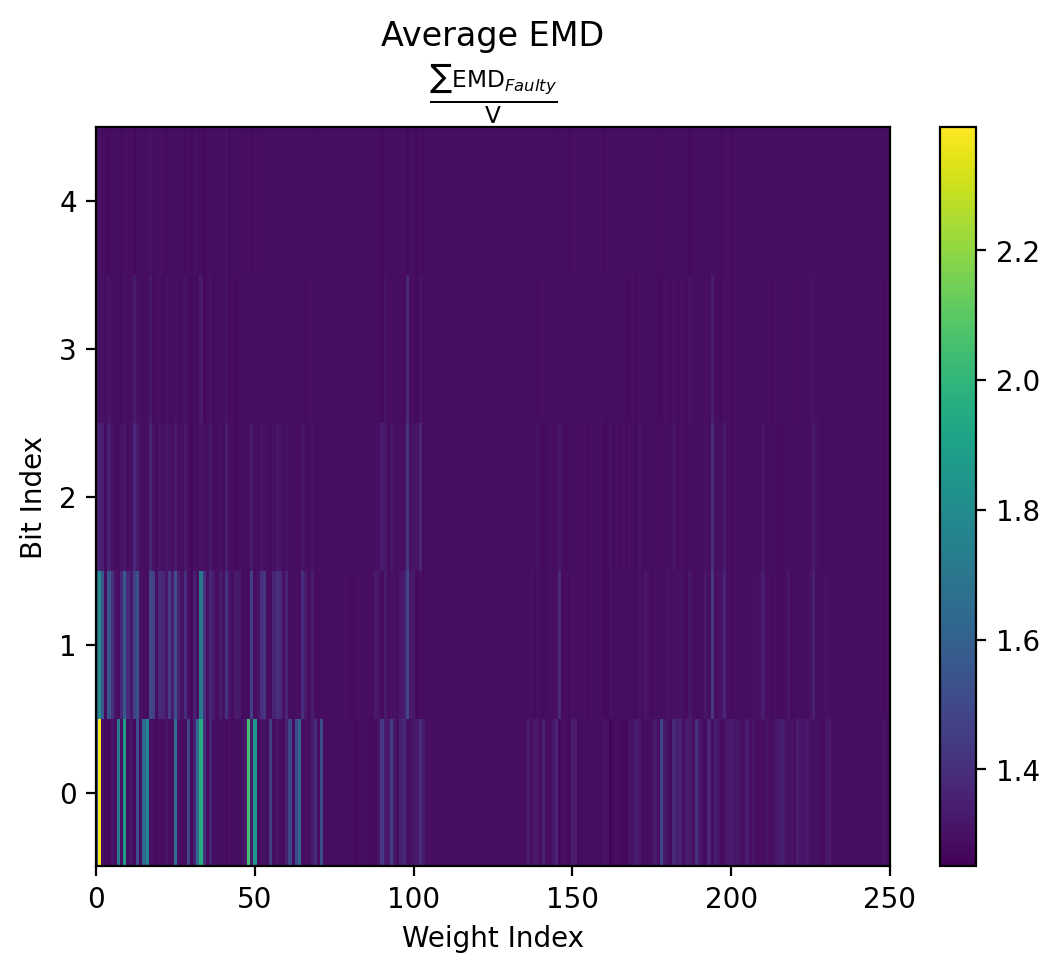

In [50]:
y = sorted(list(set(bis)))
x = sorted(list(set(wis)))

intensity = list()
for wi in sorted(list(set(wis))):
    rel_demds = demd[wi*5:(wi+1)*5] 
    if len(rel_demds) < 5:
        rel_demds += [20.4 for _ in range(5-len(rel_demds))]
    intensity.append(rel_demds)


#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

intensity = np.array(intensity).transpose()


plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale

plt.title('Average EMD\n$\\frac{\sum{}{}\mathrm{EMD}_{Faulty}}{\mathrm{V}}$')
plt.ylabel("Bit Index")
plt.xlabel("Weight Index")
# plt.rcParams["figure.figsize"] = (,3)
plt.xlim(0,250)
plt.show() #boom

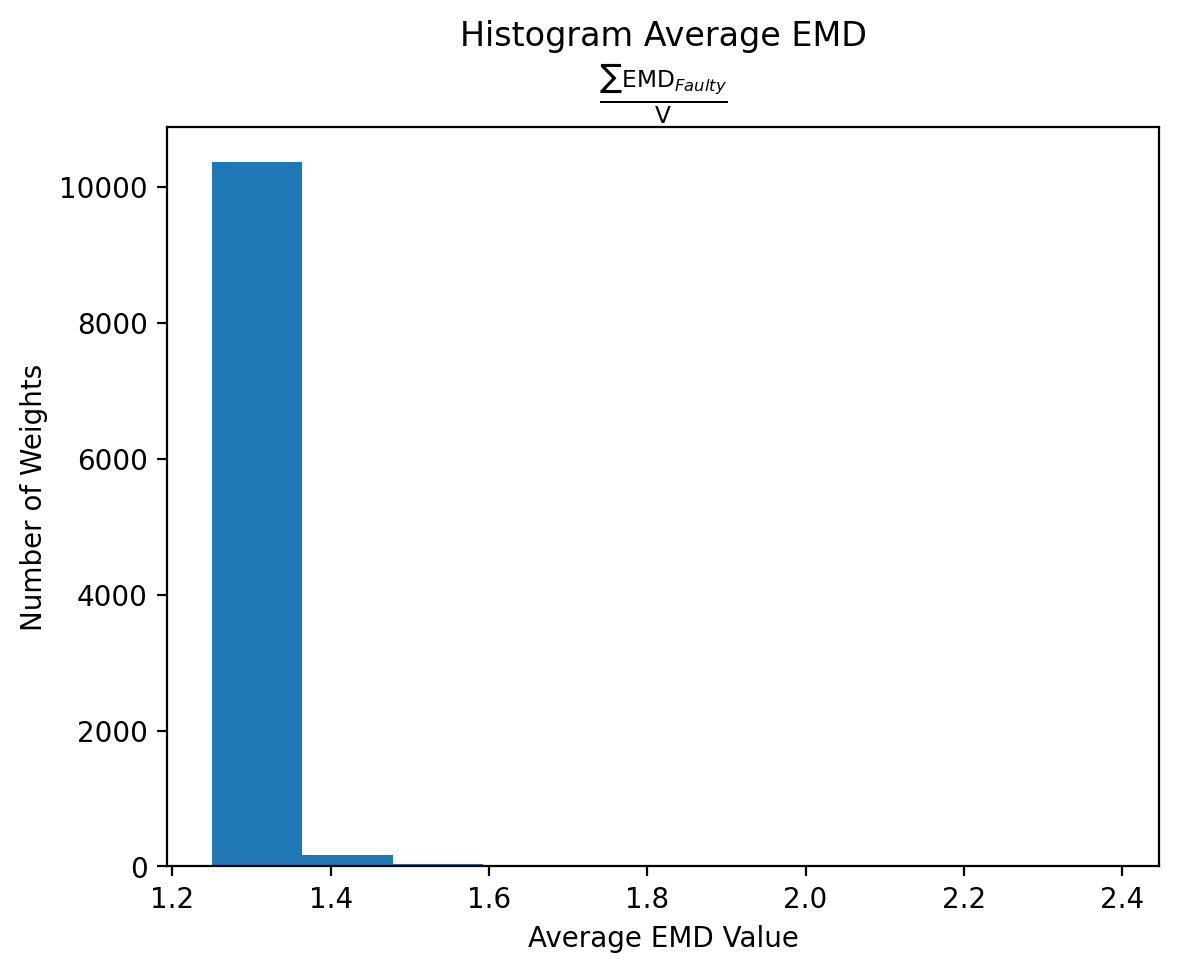

In [45]:
plt.hist(bi_to_demd.values())
plt.title('Histogram Average EMD\n$\\frac{\sum{}{}\mathrm{EMD}_{Faulty}}{\mathrm{V}}$')
plt.ylabel("Number of Weights")
plt.xlabel("Average EMD Value")
plt.show()

In [46]:
df_describe = pd.DataFrame(demd)
df_describe.describe()

,0
count,10600.000000
mean,1.293846
std,0.033344
min,1.250558
25%,1.287240
50%,1.287240
75%,1.287739
max,2.389624


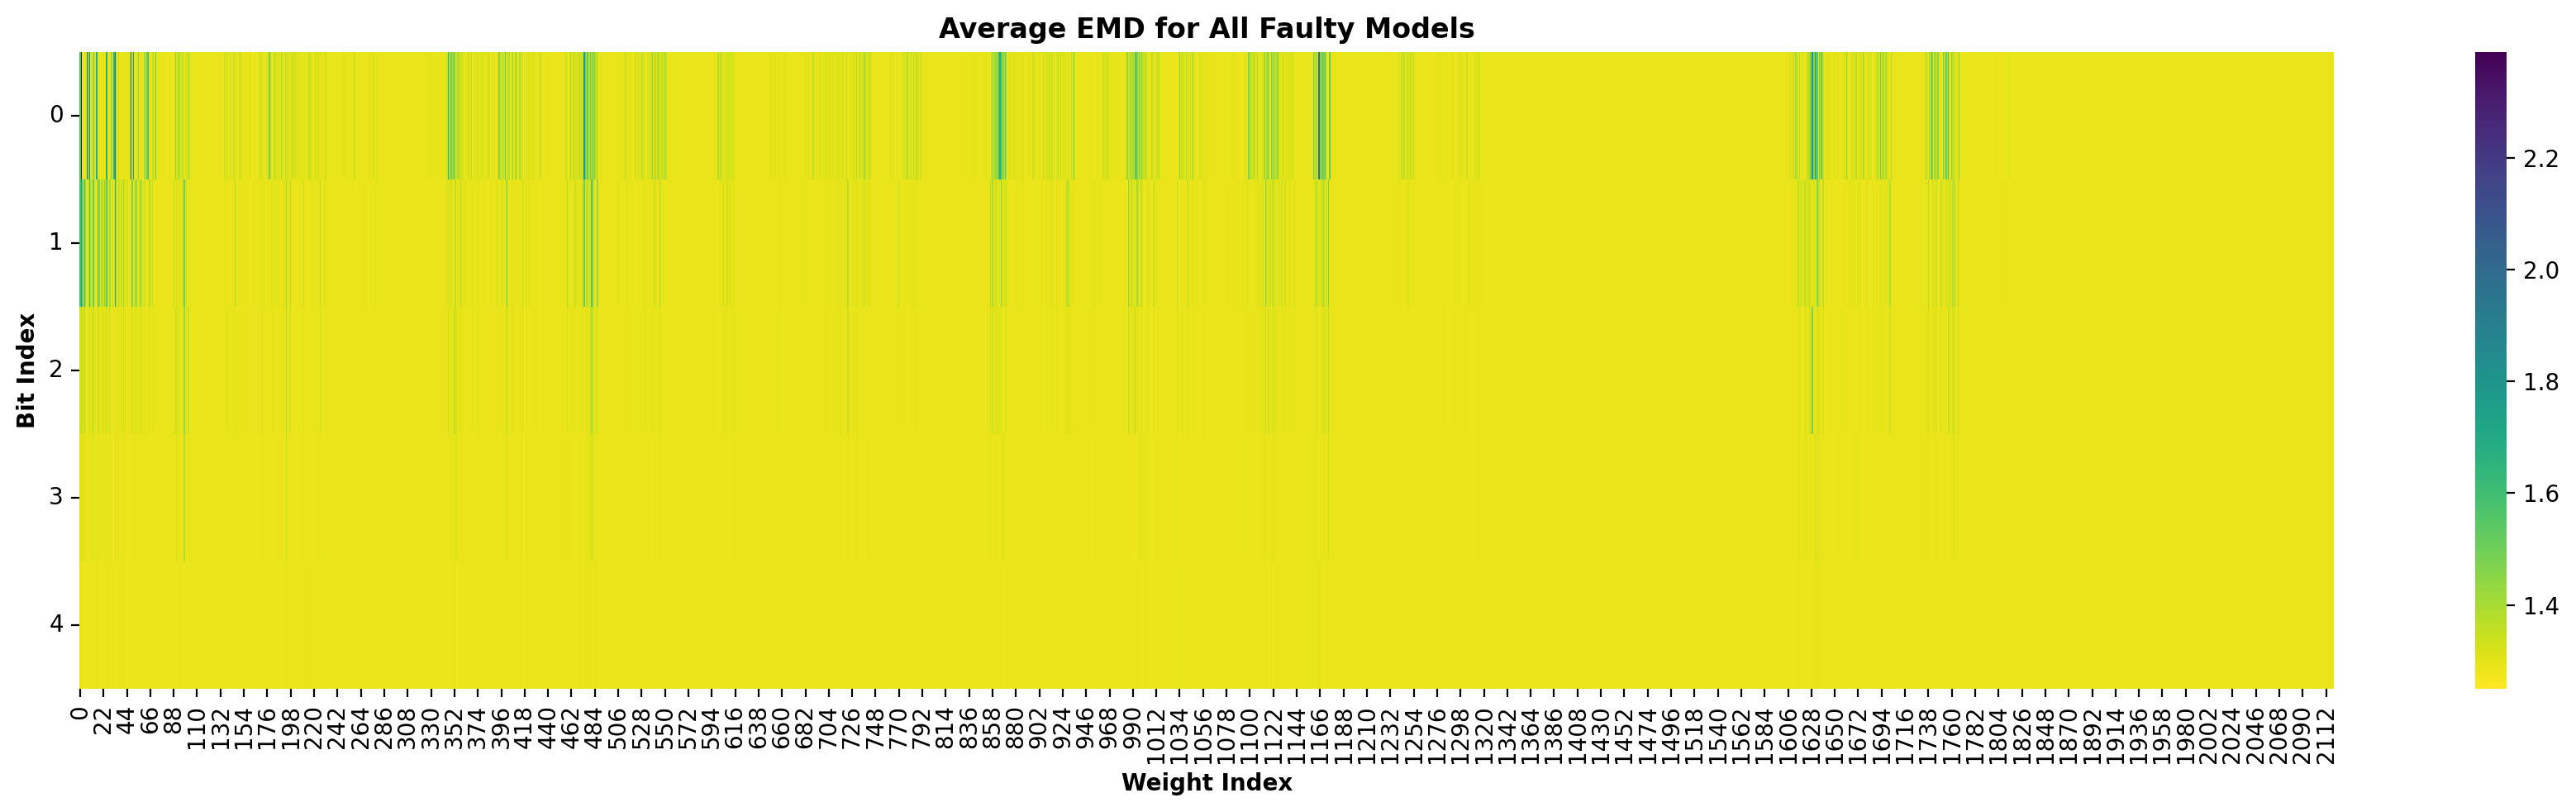

In [48]:
fig, ax = plt.subplots(figsize=(22,5))         # Sample figsize in inches
hm_ax = sns.heatmap(intensity, annot=False, fmt="f", ax=ax, cmap="viridis_r", square=False, vmin=intensity.min(), vmax=intensity.max())

hm_ax.xaxis.tick_bottom()
hm_ax.yaxis.tick_left()

hm_ax.set_title('Average EMD for All Faulty Models', fontdict={'weight': 'bold'})
hm_ax.set_xlabel("Weight Index", fontdict={'weight': 'bold'})
hm_ax.set_ylabel("Bit Index", fontdict={'weight': 'bold'})


plt.yticks(rotation=0) 

# plt.savefig(f"AVG_EMD_RAW_HEATMAP.svg", bbox_inches="tight")
# plt.savefig(f"AVG_EMD_RAW_HEATMAP.pdf", bbox_inches="tight")
plt.show()